In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM, Input
from tensorflow.keras.models import Sequential
import yfinance as yf

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)

In [2]:
# Define the list of assets for price prediction
assets = ['AAPL', 'MSFT', 'AMZN', 'GOOGL', 'TSLA', 'SPY', 'AGG', 'PSP', 'VNQ', 'SLV', 'GLD', 'USO']
# assets = ['AAPL', 'MSFT', 'AMZN', 'GOOGL', 'TSLA', 'SPY', 'AGG', 'PSP', 'VNQ', 'SLV', 'GLD', 'USO', 'DJI']
# assets = ['AAPL']

# Define the start and end dates
start_date = '2022-01-01'
end_date = '2024-01-01'

data_filepath = './data'

# Fetch historical data for each cryptocurrency
for symbol in assets:
    # Fetch historical data using yfinance
    crypto_data = yf.download(symbol, start=start_date, end=end_date)
    
    # Save data to a CSV file
    file_name = os.path.join(data_filepath, f"{symbol}_data.csv")
    crypto_data.to_csv(file_name)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [3]:
def to_sequences(data, seq_len):
    d = []

    for index in range(len(data) - seq_len):
        d.append(data[index: index + seq_len])

    return np.array(d)


# Function to preprocess data
def preprocess_data(data_raw, seq_len, train_split):
    data = to_sequences(data_raw, seq_len)
    num_train = int(train_split * data.shape[0])
    X_train = data[:num_train, :-1, :]
    y_train = data[:num_train, -1, :]
    X_test = data[num_train:, :-1, :]
    y_test = data[num_train:, -1, :]
    return X_train, y_train, X_test, y_test


In [4]:
SEQ_LEN = 100
DROPOUT = 0.2
WINDOW_SIZE = SEQ_LEN - 1
scaler = MinMaxScaler()
BATCH_SIZE = 64

# Function to train a model
def train_model(X_train, y_train, X_test, y_test):
    

    input_shape = (WINDOW_SIZE, X_train.shape[-1])
    inputs = Input(shape=input_shape)
    model = keras.Sequential()
    model.add(inputs)
    model.add(Bidirectional(LSTM(WINDOW_SIZE, return_sequences=True)))
    model.add(Dropout(rate=DROPOUT))
    model.add(Bidirectional(LSTM((WINDOW_SIZE * 2), return_sequences=True)))
    model.add(Dropout(rate=DROPOUT))
    model.add(Bidirectional(LSTM(WINDOW_SIZE, return_sequences=False)))
    model.add(Dense(units=1))
    model.add(Activation('linear'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    history = model.fit(X_train, y_train, epochs=50, batch_size=BATCH_SIZE, shuffle=False, validation_split=0.1)
    return model, history


In [5]:
# Function to plot loss history
def plot_loss(history, scaler, currency, df):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f"{currency} Model Loss")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()


In [6]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def predict_and_plot(model, X_test, y_test, scaler, currency, df):
    y_hat = model.predict(X_test)
    y_test_inverse = scaler.inverse_transform(y_test)
    y_hat_inverse = scaler.inverse_transform(y_hat)
    
    # Get the original dates from the dataframe
    dates = df['Date'].values[-len(y_test_inverse):]
    
    # Plotting
    plt.plot(dates, y_test_inverse, label="Actual Price", color='green')
    plt.plot(dates, y_hat_inverse, label=f"{currency} Price", color='red')
    plt.title(f"{currency} Price")
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend(loc='best')

    # Slant the dates on the x-axis
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=7))
    plt.xticks(rotation=45)
    
    plt.show()


Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 558ms/step - loss: 0.0928 - val_loss: 0.0212
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 451ms/step - loss: 0.0355 - val_loss: 0.0084
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 459ms/step - loss: 0.0105 - val_loss: 0.0100
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 488ms/step - loss: 0.0136 - val_loss: 0.0087
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 503ms/step - loss: 0.0143 - val_loss: 0.0152
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 511ms/step - loss: 0.0112 - val_loss: 0.0331
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 492ms/step - loss: 0.0097 - val_loss: 0.0222
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 537ms/step - loss: 0.0148 - val_loss: 0.0076
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 491ms/step - loss: 0.0072 - val_loss: 0.0099
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 501ms/step - loss: 0.0069 - val_loss: 0.0150
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 486ms/step - loss: 0.0071 - val_loss: 0.0085
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 502ms/step - loss: 0.0062 - val_lo

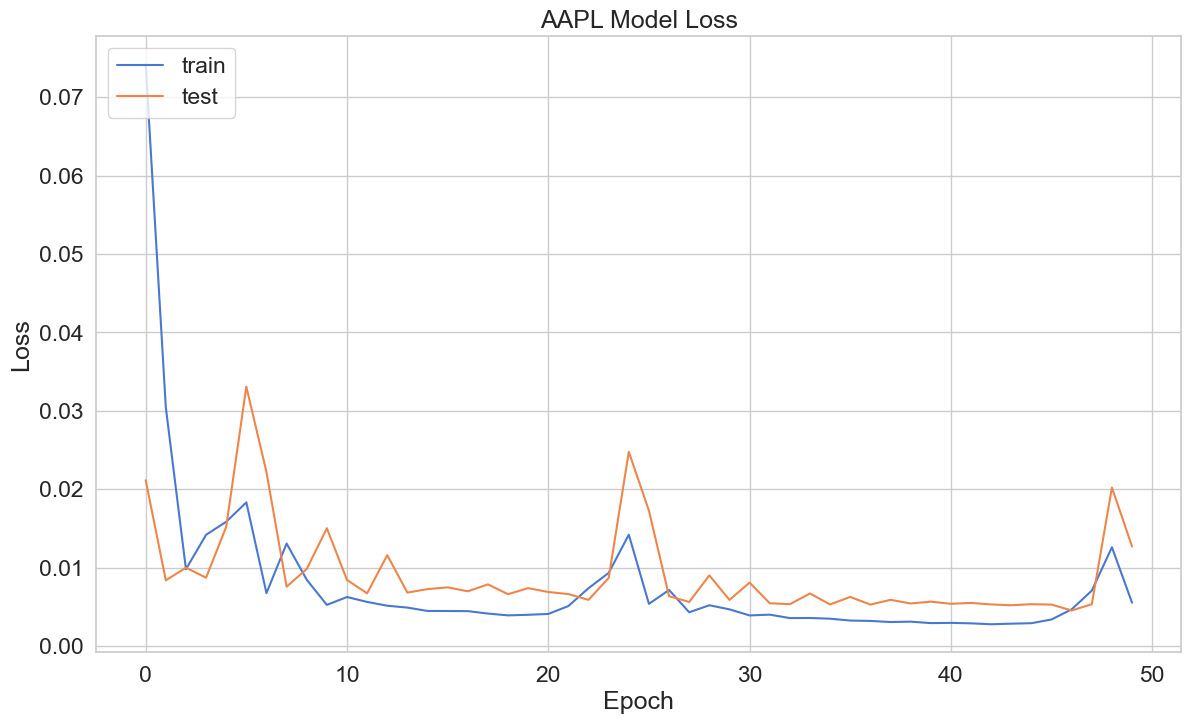

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 313ms/step


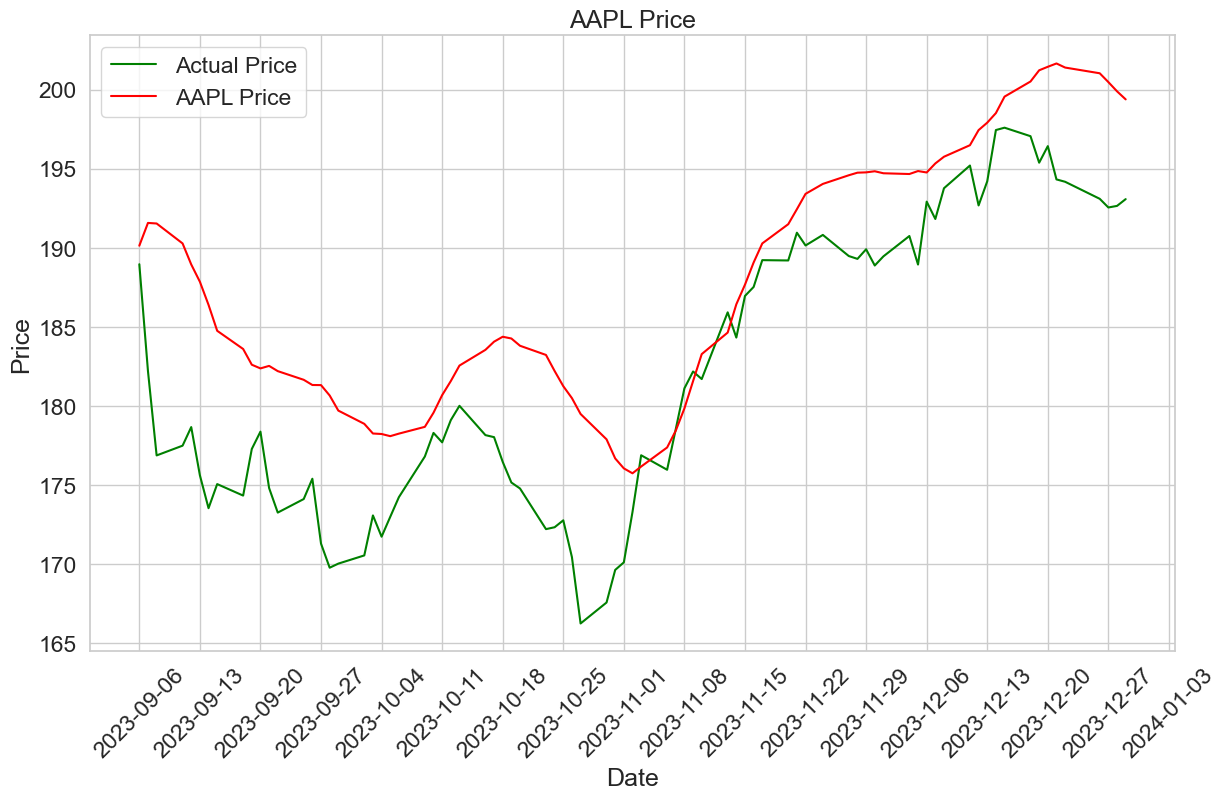

Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 593ms/step - loss: 0.0481 - val_loss: 0.1410
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 549ms/step - loss: 0.0968 - val_loss: 0.0392
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 530ms/step - loss: 0.0062 - val_loss: 0.0222
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 554ms/step - loss: 0.0080 - val_loss: 0.0036
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 459ms/step - loss: 0.0087 - val_loss: 0.0239
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 538ms/step - loss: 0.0076 - val_loss: 0.0135
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 484ms/step - loss: 0.0067 - val_loss: 0.0060
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 488ms/step - loss: 0.0047 - val_loss: 0.0070
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 517ms/step - loss: 0.0046 - val_loss: 0.0042
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 559ms/step - loss: 0.0043 - val_loss: 0.0068
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 533ms/step - loss: 0.0036 - val_loss: 0.0022
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 579ms/step - loss: 0.0039 - val_lo

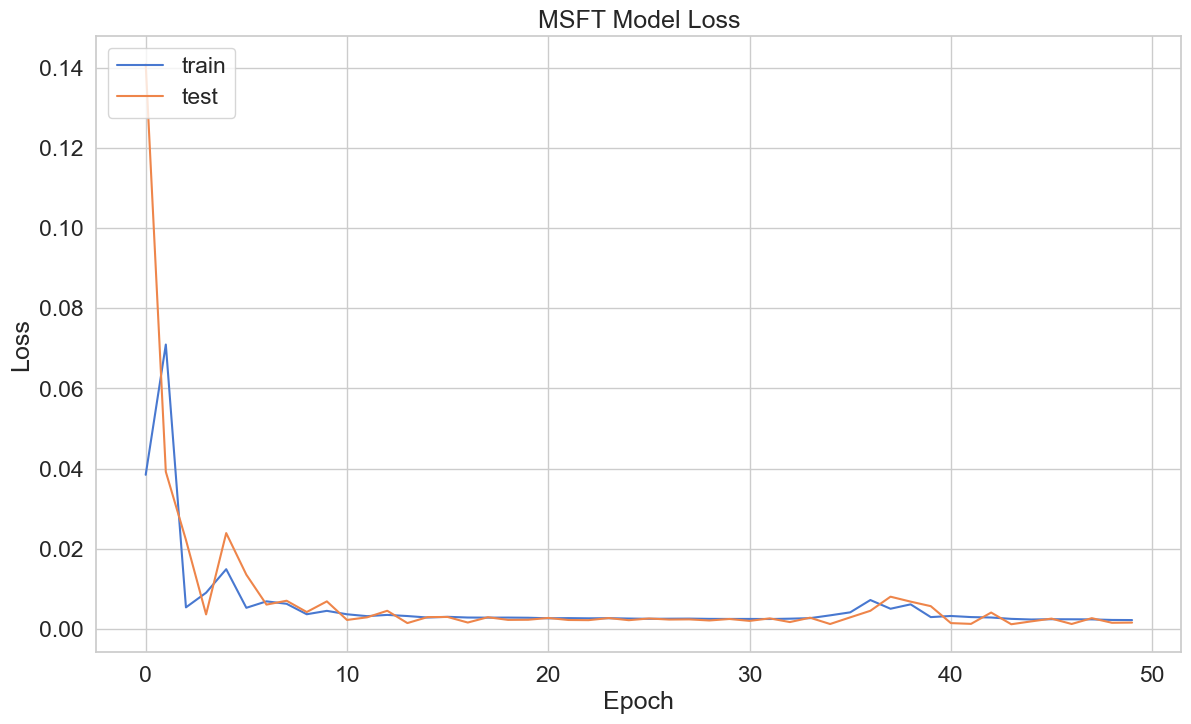

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 245ms/step


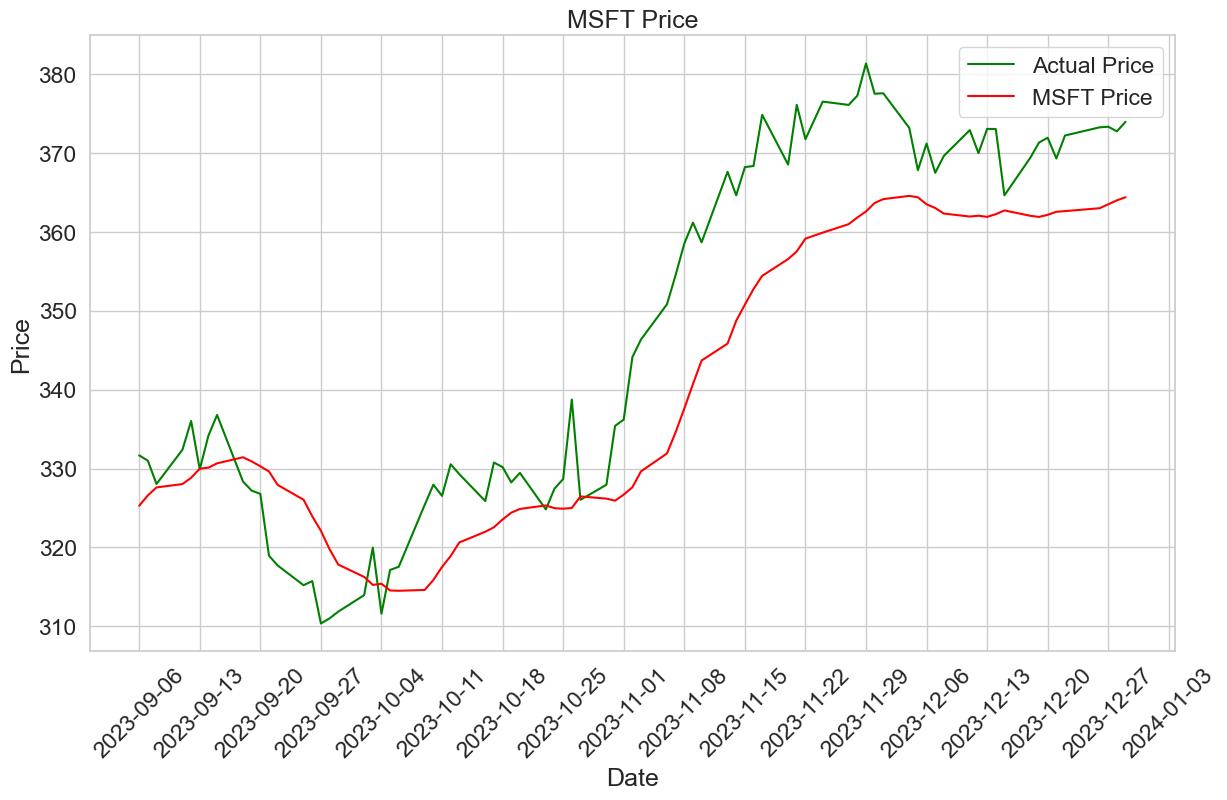

Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 567ms/step - loss: 0.1228 - val_loss: 0.0132
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 466ms/step - loss: 0.0135 - val_loss: 0.0271
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 455ms/step - loss: 0.0169 - val_loss: 0.0147
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 467ms/step - loss: 0.0130 - val_loss: 0.0526
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 453ms/step - loss: 0.0266 - val_loss: 0.0018
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 461ms/step - loss: 0.0126 - val_loss: 0.0018
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 445ms/step - loss: 0.0080 - val_loss: 0.0152
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 470ms/step - loss: 0.0086 - val_loss: 0.0032
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 451ms/step - loss: 0.0068 - val_loss: 0.0027
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 436ms/step - loss: 0.0072 - val_loss: 0.0035
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 447ms/step - loss: 0.0065 - val_loss: 0.0022
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 453ms/step - loss: 0.0062 - val_lo

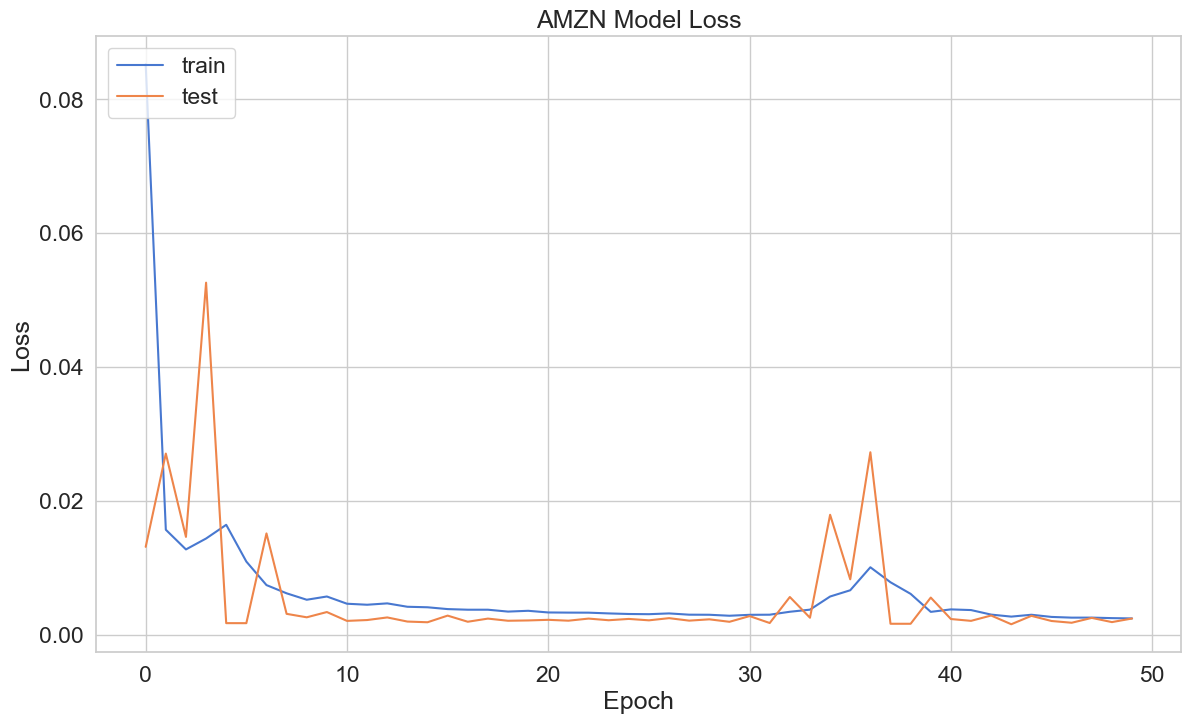

2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/stepWARNING:tensorflow:6 out of the last 9 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x2da8ea3a0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 284ms/step


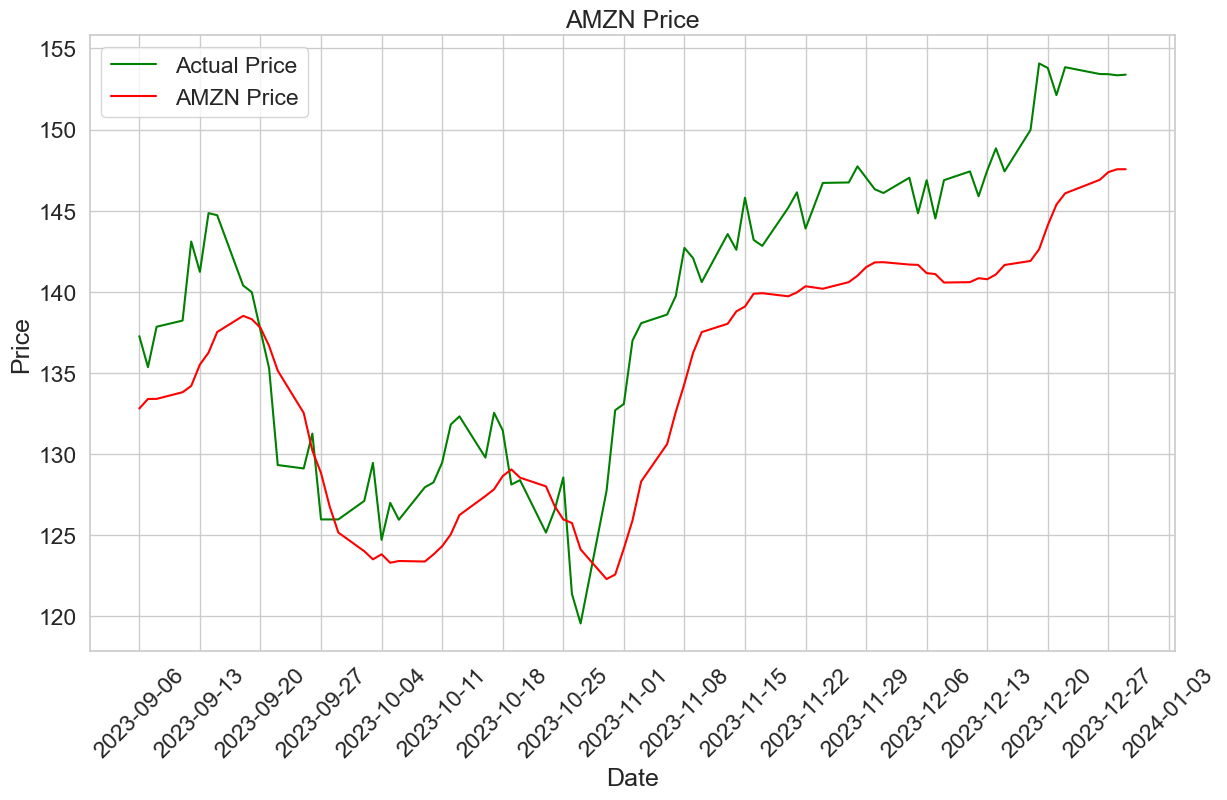

Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 607ms/step - loss: 0.1227 - val_loss: 0.0034
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 481ms/step - loss: 0.0664 - val_loss: 0.1869
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 500ms/step - loss: 0.0346 - val_loss: 0.0062
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 480ms/step - loss: 0.0161 - val_loss: 0.0038
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 496ms/step - loss: 0.0100 - val_loss: 0.0483
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 492ms/step - loss: 0.0098 - val_loss: 0.0085
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 510ms/step - loss: 0.0068 - val_loss: 0.0024
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 501ms/step - loss: 0.0065 - val_loss: 0.0153
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 500ms/step - loss: 0.0072 - val_loss: 0.0052
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 463ms/step - loss: 0.0057 - val_loss: 0.0024
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 478ms/step - loss: 0.0050 - val_loss: 0.0078
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 454ms/step - loss: 0.0061 - val_lo

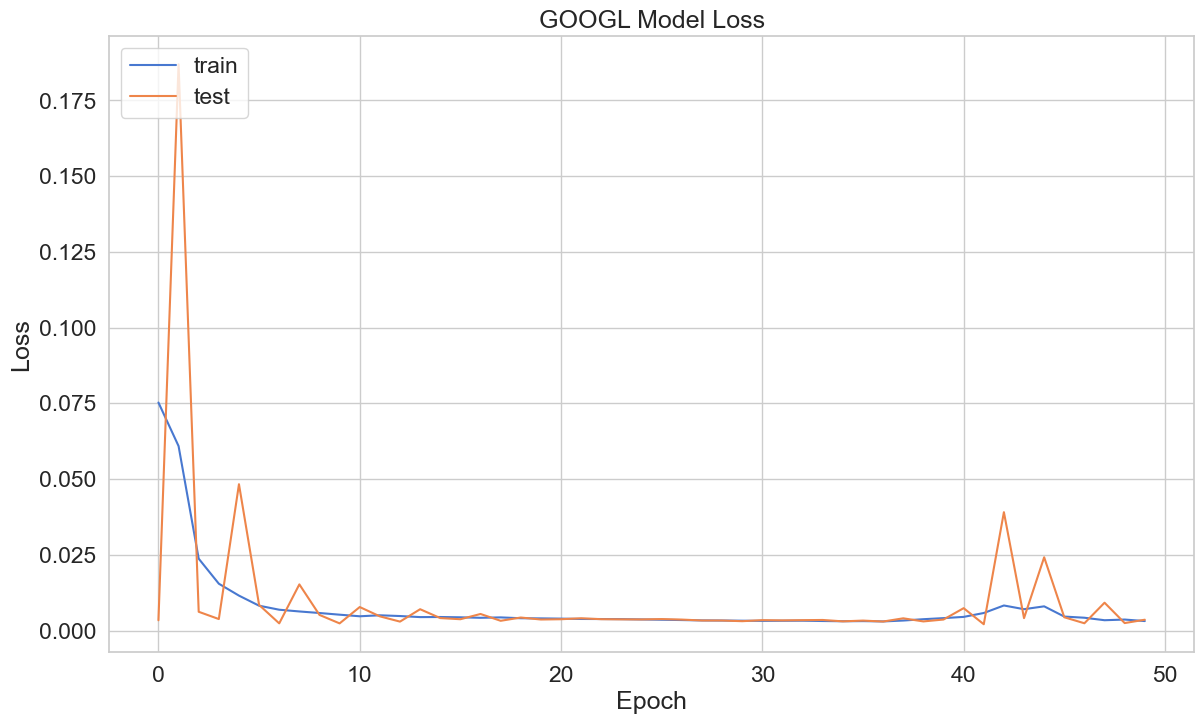

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 279ms/step


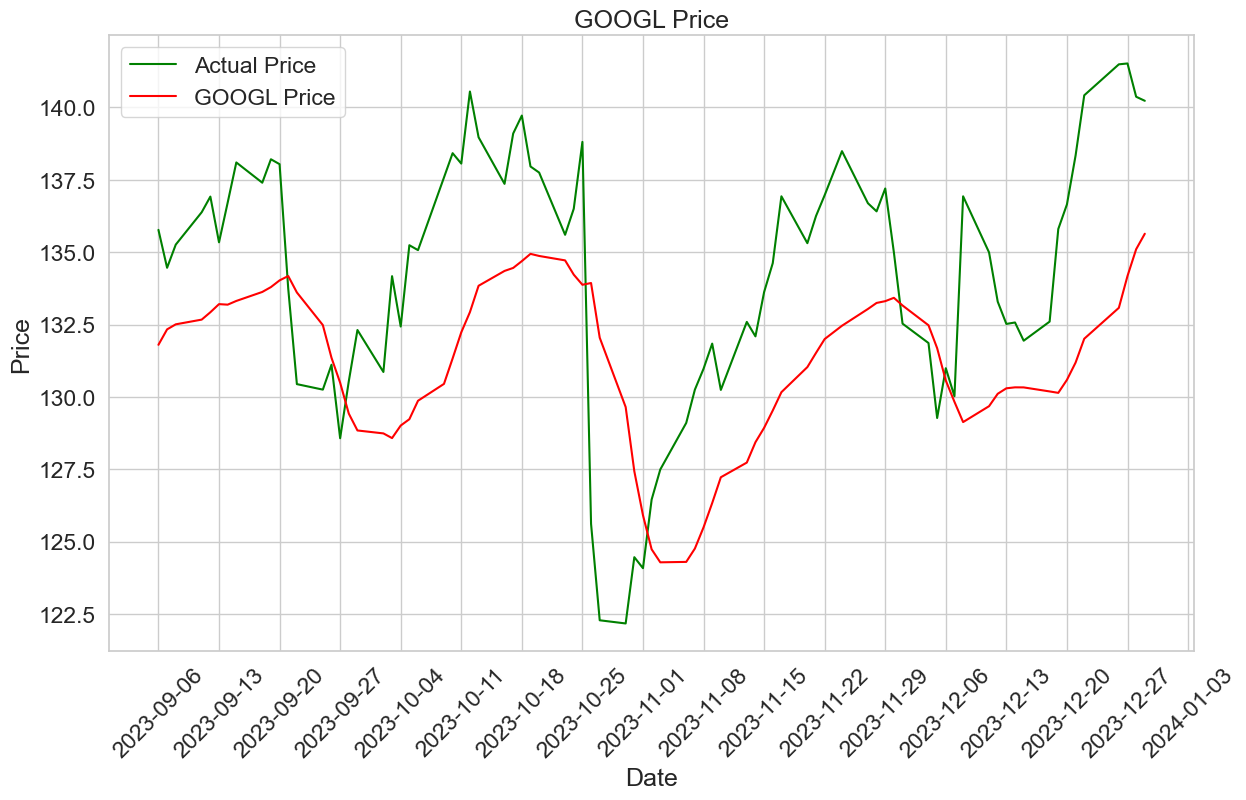

Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 539ms/step - loss: 0.1421 - val_loss: 0.0221
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 463ms/step - loss: 0.0111 - val_loss: 0.0020
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 474ms/step - loss: 0.0097 - val_loss: 0.0018
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 432ms/step - loss: 0.0052 - val_loss: 0.0018
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 440ms/step - loss: 0.0055 - val_loss: 0.0043
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 468ms/step - loss: 0.0048 - val_loss: 0.0018
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 449ms/step - loss: 0.0059 - val_loss: 0.0065
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 462ms/step - loss: 0.0042 - val_loss: 0.0028
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 557ms/step - loss: 0.0080 - val_loss: 0.0086
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 472ms/step - loss: 0.0046 - val_loss: 0.0104
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 501ms/step - loss: 0.0120 - val_loss: 0.0154
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 453ms/step - loss: 0.0098 - val_lo

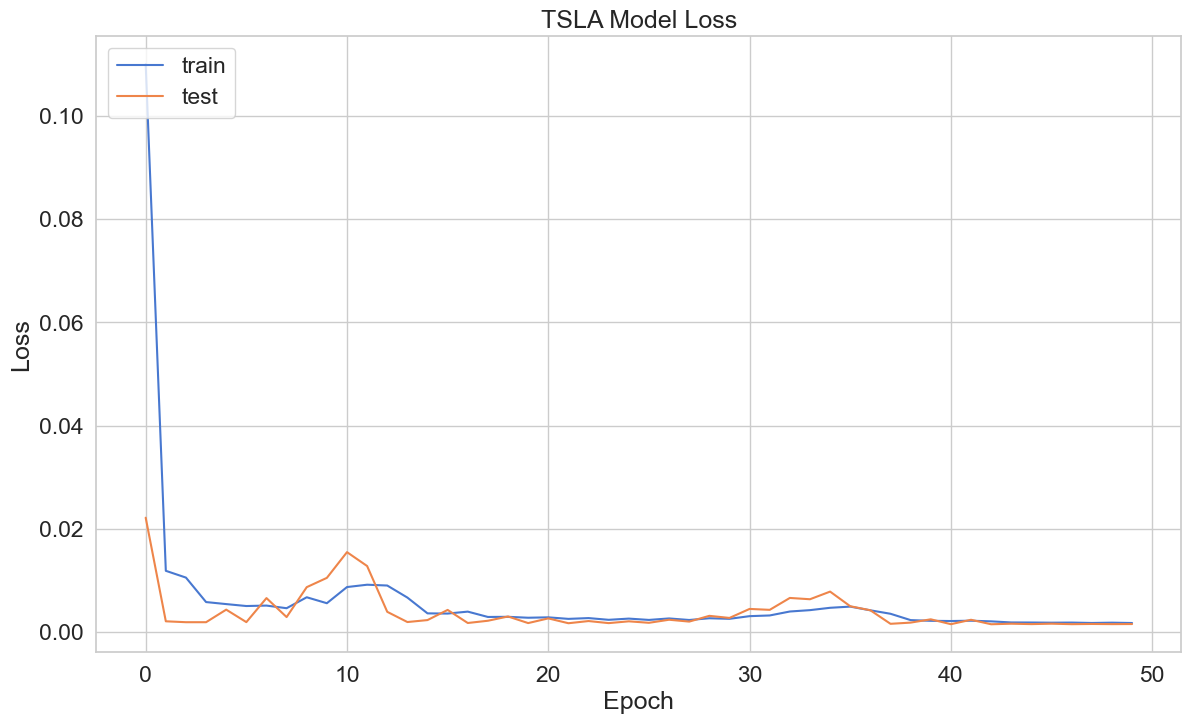

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 273ms/step


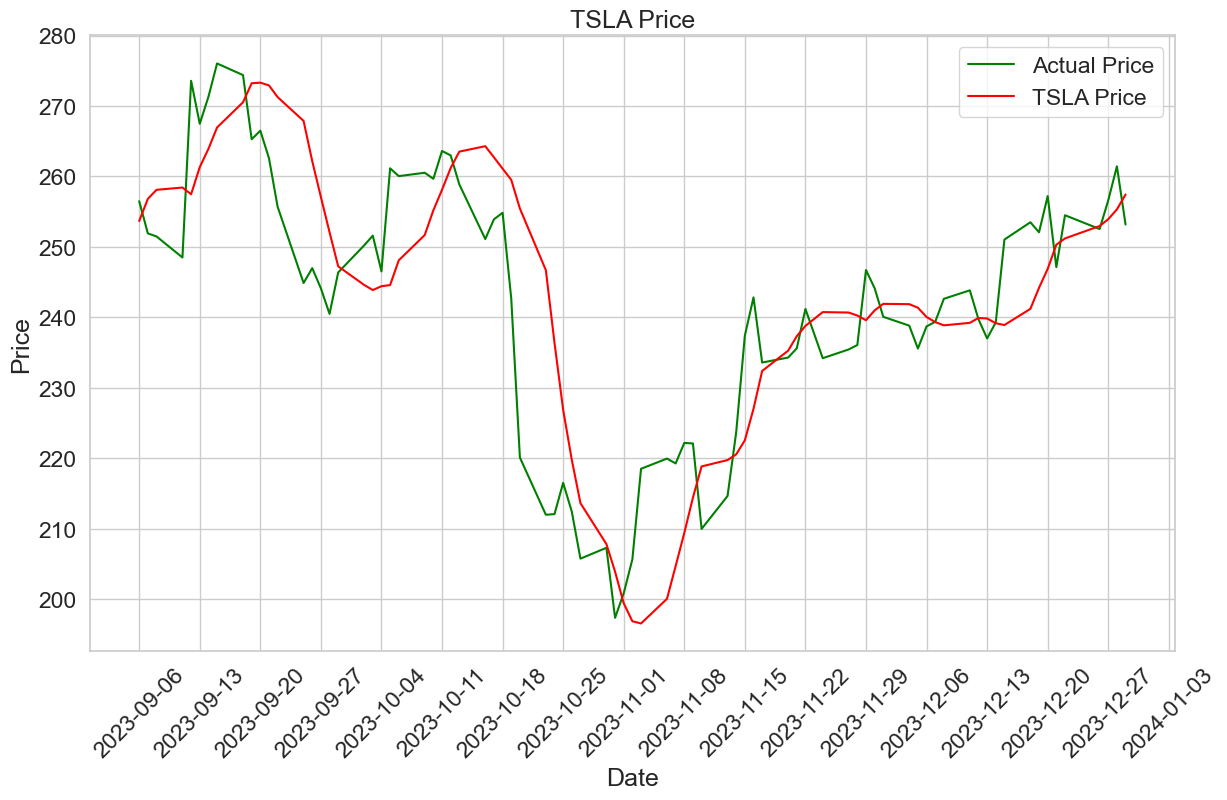

Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 618ms/step - loss: 0.0580 - val_loss: 0.0566
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 483ms/step - loss: 0.1201 - val_loss: 0.1982
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 504ms/step - loss: 0.0220 - val_loss: 0.0050
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 515ms/step - loss: 0.0233 - val_loss: 0.0029
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 558ms/step - loss: 0.0168 - val_loss: 0.0396
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 578ms/step - loss: 0.0083 - val_loss: 0.0026
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 508ms/step - loss: 0.0115 - val_loss: 0.0053
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 456ms/step - loss: 0.0093 - val_loss: 0.0065
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 488ms/step - loss: 0.0076 - val_loss: 0.0040
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 526ms/step - loss: 0.0081 - val_loss: 0.0064
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 502ms/step - loss: 0.0072 - val_loss: 0.0023
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 495ms/step - loss: 0.0071 - val_lo

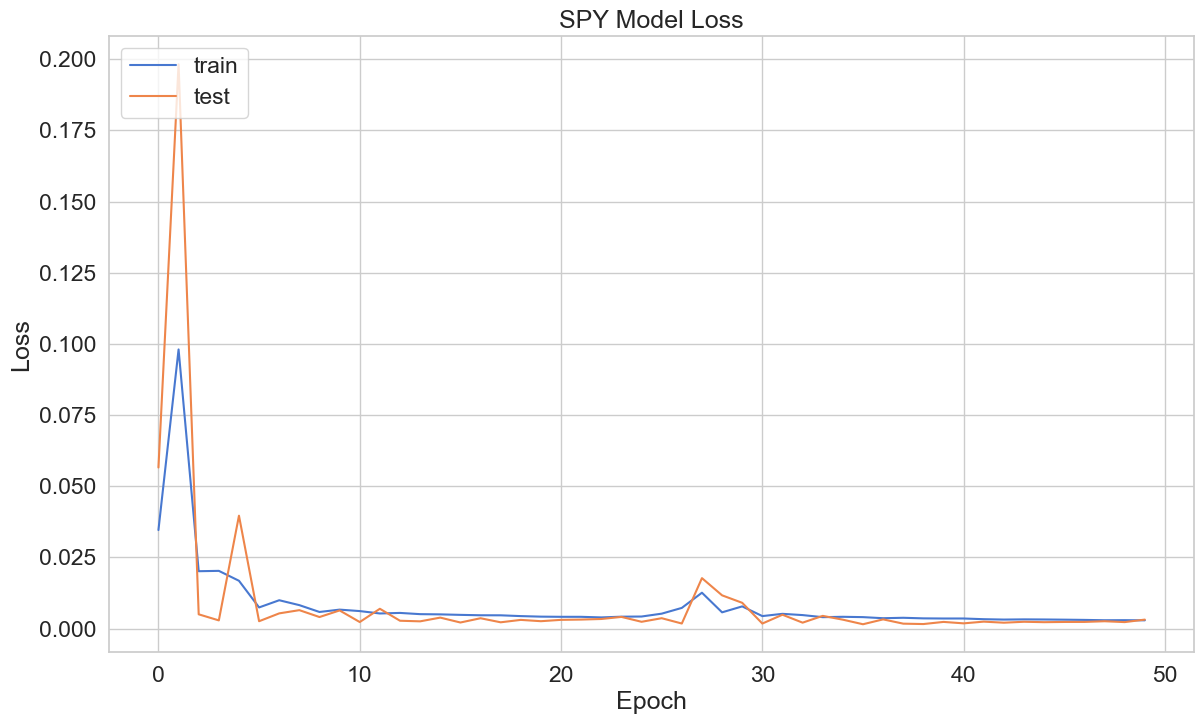

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 348ms/step


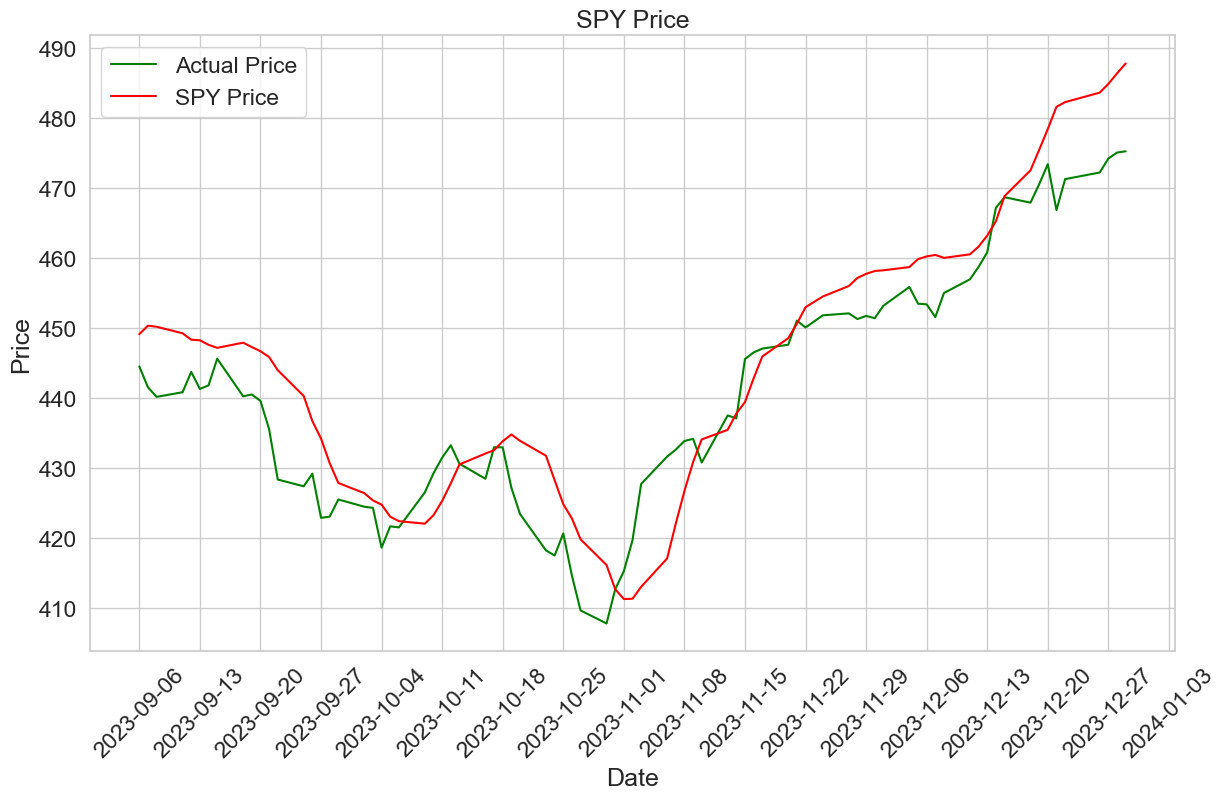

Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 642ms/step - loss: 0.0849 - val_loss: 0.0142
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 541ms/step - loss: 0.0427 - val_loss: 0.0226
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 529ms/step - loss: 0.0251 - val_loss: 0.0176
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 563ms/step - loss: 0.0254 - val_loss: 0.0017
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 626ms/step - loss: 0.0079 - val_loss: 0.0021
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 547ms/step - loss: 0.0071 - val_loss: 0.0047
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 559ms/step - loss: 0.0081 - val_loss: 0.0030
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 468ms/step - loss: 0.0058 - val_loss: 0.0012
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 469ms/step - loss: 0.0054 - val_loss: 0.0020
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 471ms/step - loss: 0.0047 - val_loss: 0.0023
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 523ms/step - loss: 0.0042 - val_loss: 0.0011
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 534ms/step - loss: 0.0040 - val_lo

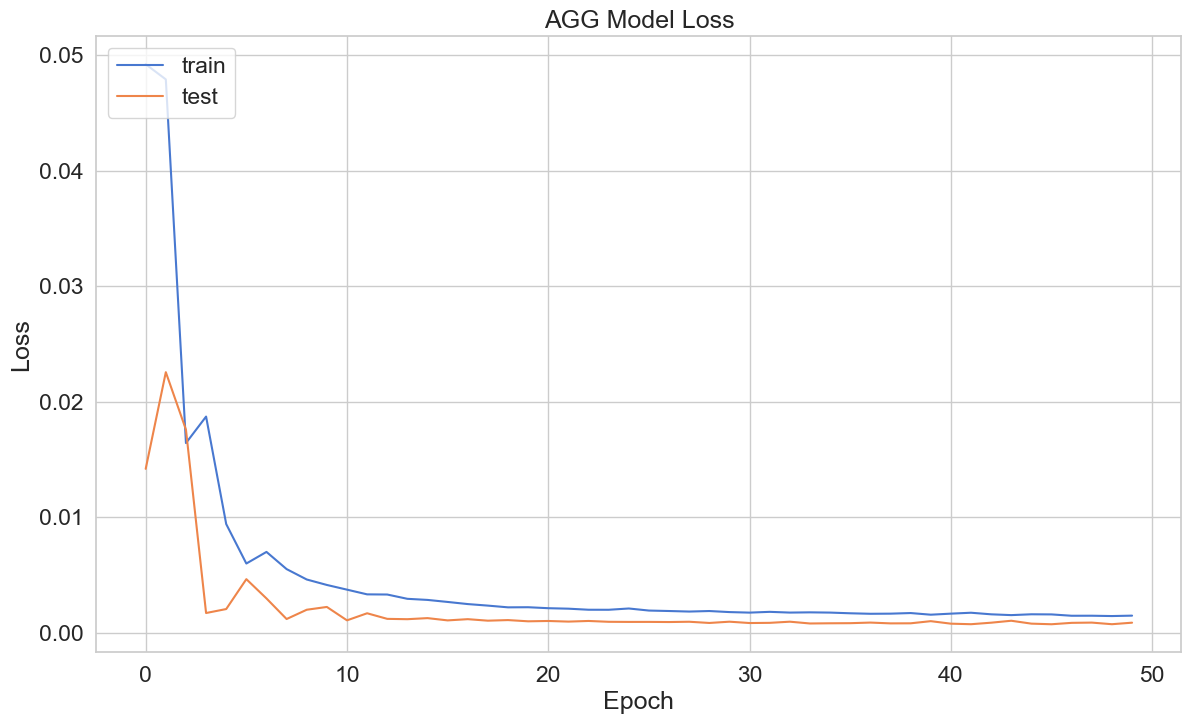

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 266ms/step


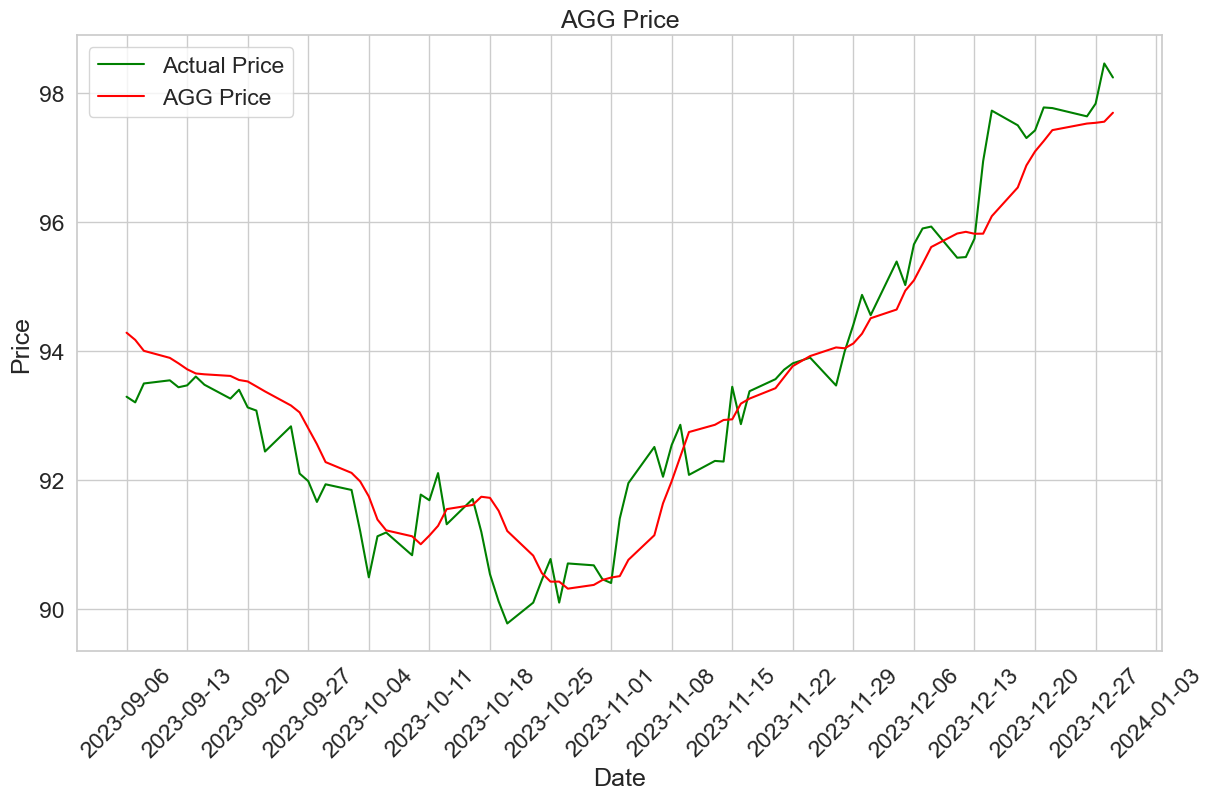

Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 533ms/step - loss: 0.0529 - val_loss: 0.0100
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 445ms/step - loss: 0.0290 - val_loss: 0.0500
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 443ms/step - loss: 0.0098 - val_loss: 0.0020
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 516ms/step - loss: 0.0221 - val_loss: 0.0189
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 481ms/step - loss: 0.0067 - val_loss: 0.0119
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 481ms/step - loss: 0.0050 - val_loss: 0.0013
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 463ms/step - loss: 0.0080 - val_loss: 0.0044
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 717ms/step - loss: 0.0044 - val_loss: 0.0050
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 498ms/step - loss: 0.0041 - val_loss: 0.0011
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - loss: 0.0042 - val_loss: 0.0015
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 629ms/step - loss: 0.0034 - val_loss: 0.0013
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 670ms/step - loss: 0.0036 - val_loss

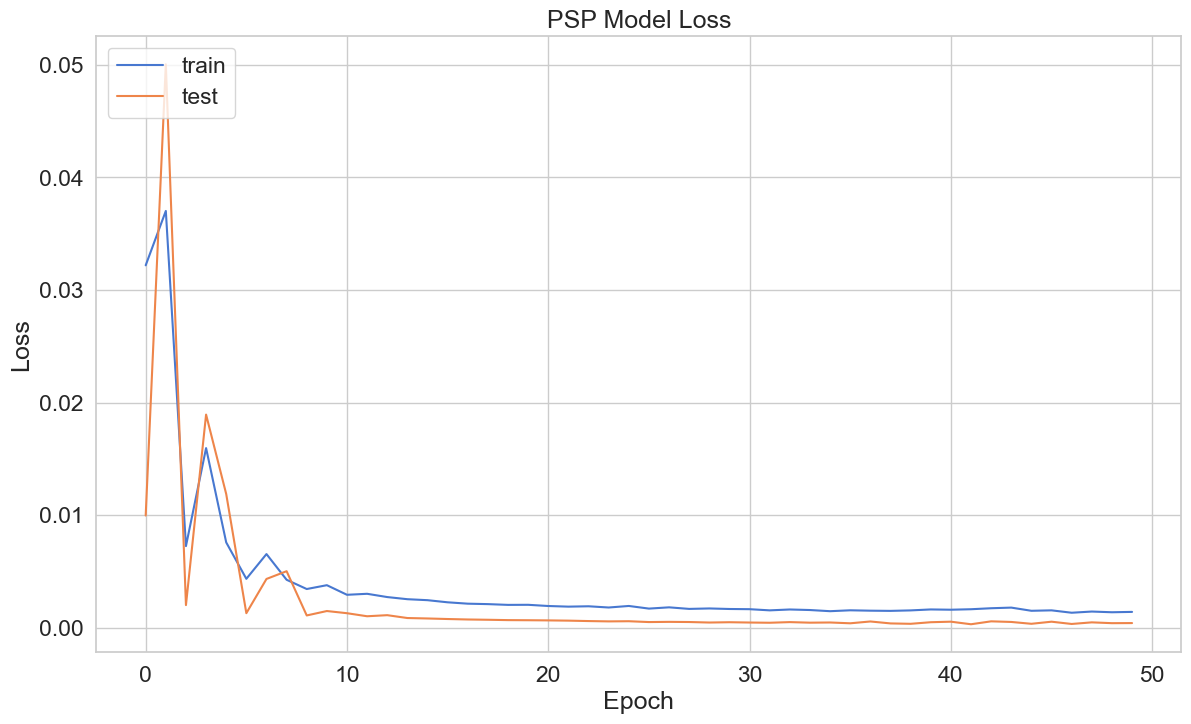

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 308ms/step


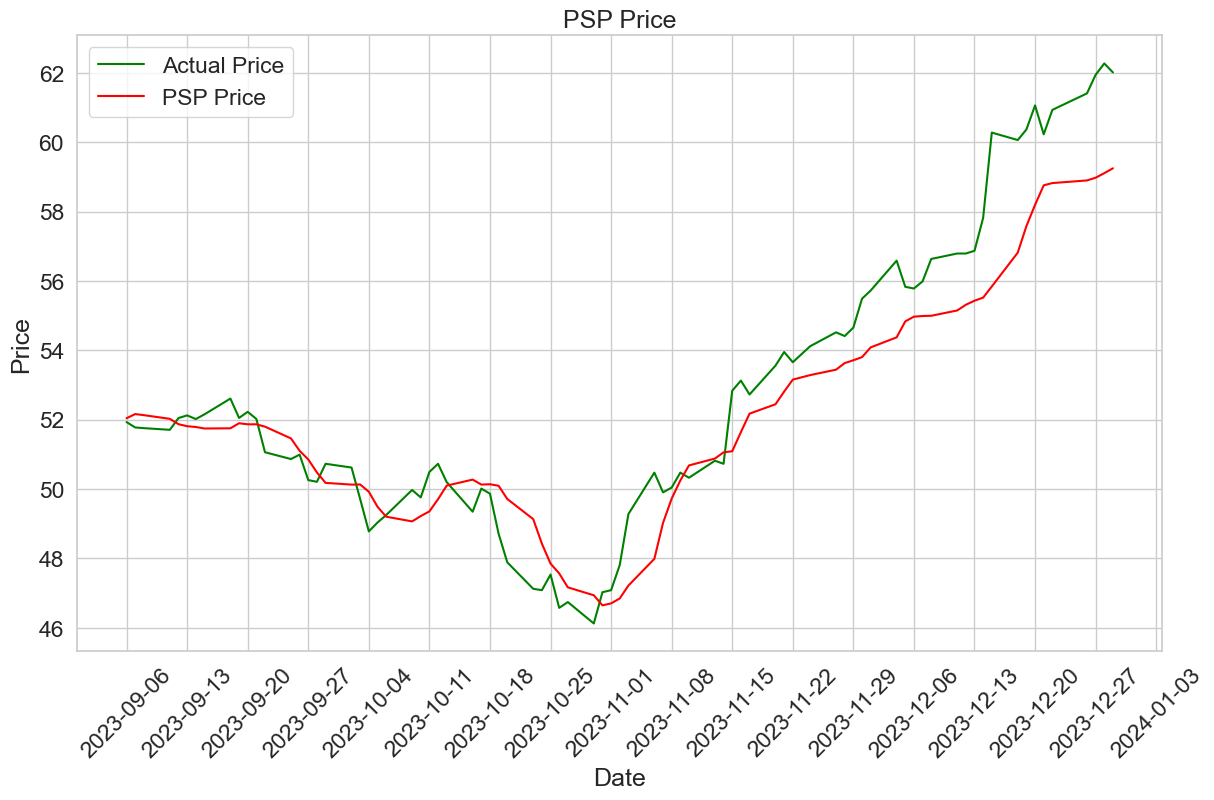

Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 669ms/step - loss: 0.1187 - val_loss: 0.0105
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 479ms/step - loss: 0.0111 - val_loss: 0.0027
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 458ms/step - loss: 0.0102 - val_loss: 0.0054
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 459ms/step - loss: 0.0111 - val_loss: 0.0013
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 479ms/step - loss: 0.0071 - val_loss: 0.0037
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 484ms/step - loss: 0.0113 - val_loss: 0.0021
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 481ms/step - loss: 0.0065 - val_loss: 0.0053
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 519ms/step - loss: 0.0126 - val_loss: 0.0042
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 576ms/step - loss: 0.0096 - val_loss: 0.0086
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 556ms/step - loss: 0.0155 - val_loss: 0.0025
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 568ms/step - loss: 0.0090 - val_loss: 0.0025
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 944ms/step - loss: 0.0067 - val_lo

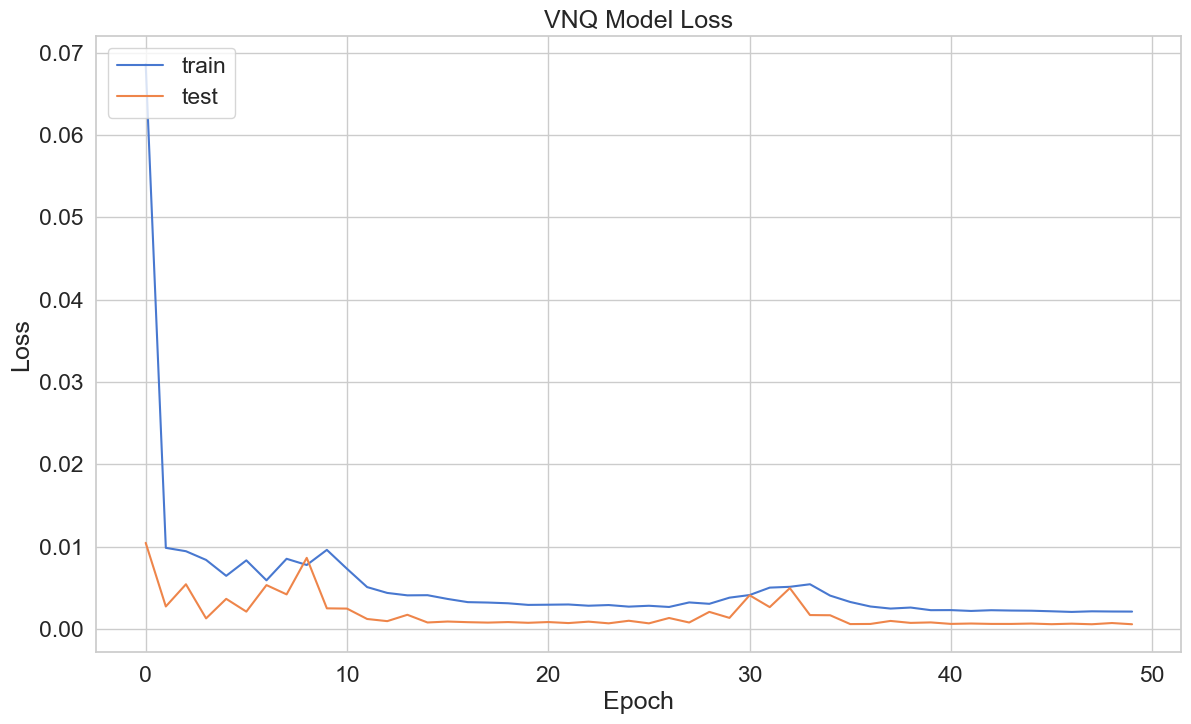

3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step


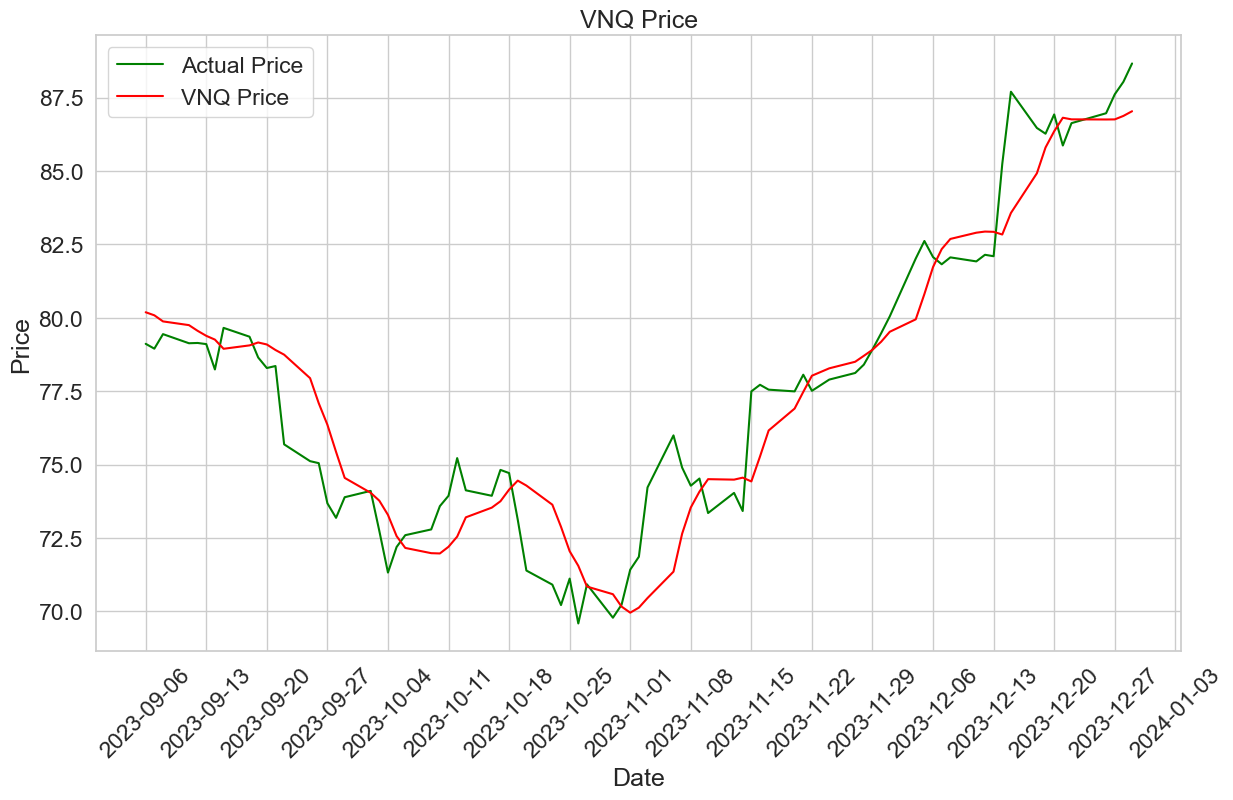

Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 825ms/step - loss: 0.0637 - val_loss: 0.0125
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 577ms/step - loss: 0.0820 - val_loss: 0.0464
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - loss: 0.0139 - val_loss: 0.0214
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 720ms/step - loss: 0.0421 - val_loss: 0.0233
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - loss: 0.0108 - val_loss: 0.0139
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 689ms/step - loss: 0.0185 - val_loss: 0.0104
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 505ms/step - loss: 0.0104 - val_loss: 0.0122
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 787ms/step - loss: 0.0096 - val_loss: 0.0105
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 643ms/step - loss: 0.0091 - val_loss: 0.0111
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 679ms/step - loss: 0.0077 - val_loss: 0.0090
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 627ms/step - loss: 0.0083 - val_loss: 0.0085
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 824ms/step - loss: 0.0076 - val_loss: 0

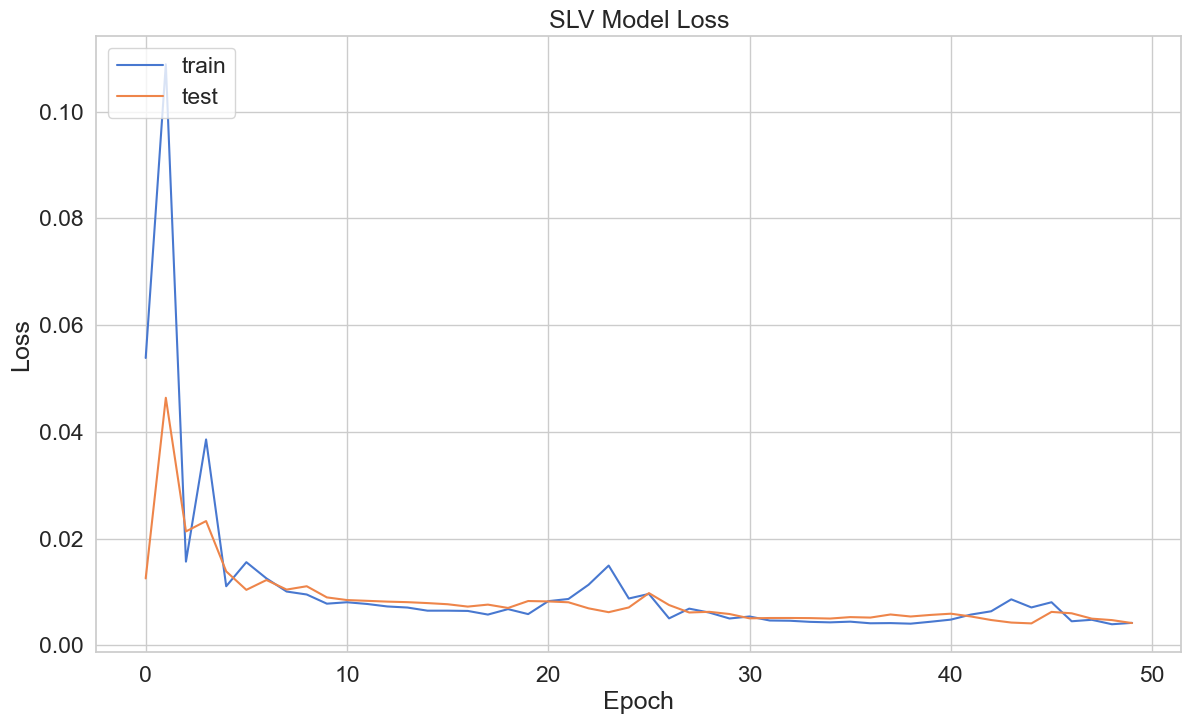

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 302ms/step


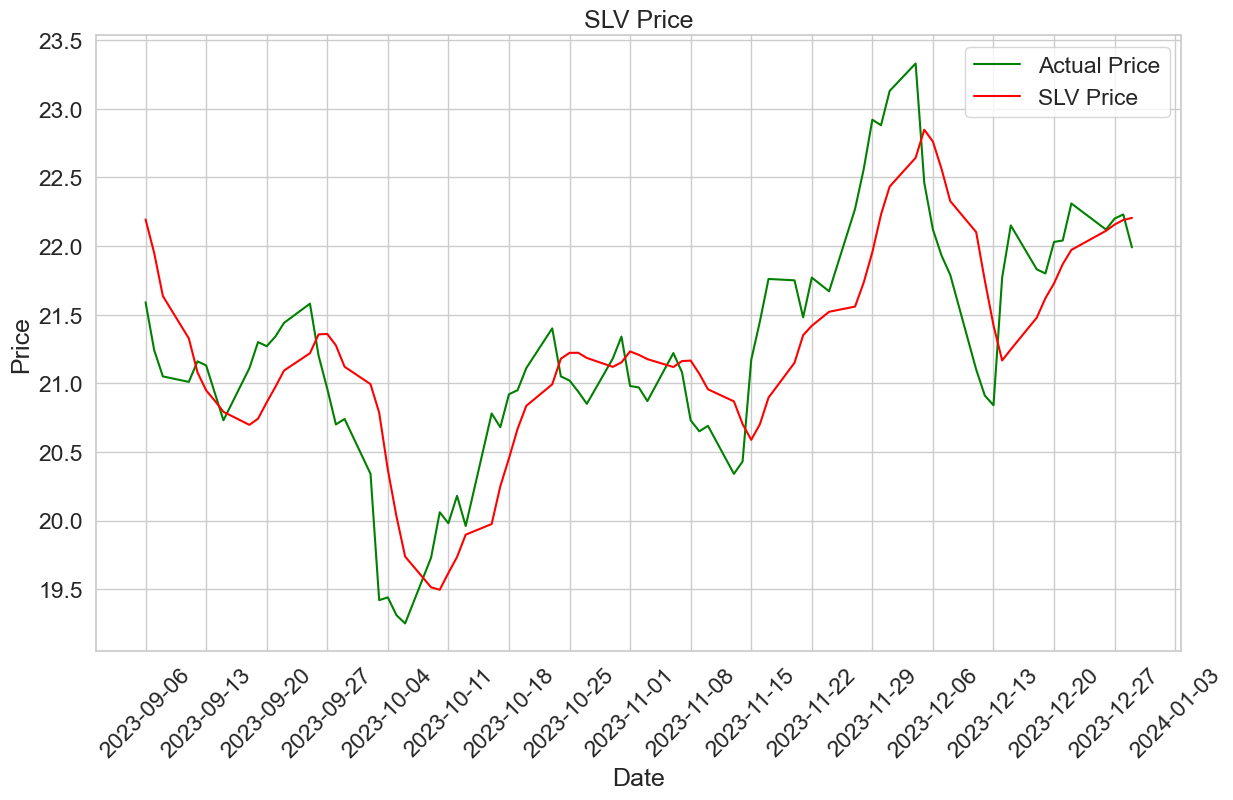

Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 536ms/step - loss: 0.0859 - val_loss: 0.0372
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 415ms/step - loss: 0.0742 - val_loss: 0.1011
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 406ms/step - loss: 0.0213 - val_loss: 0.0261
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 431ms/step - loss: 0.0355 - val_loss: 0.0027
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 442ms/step - loss: 0.0183 - val_loss: 0.0181
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 478ms/step - loss: 0.0067 - val_loss: 0.0061
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 426ms/step - loss: 0.0124 - val_loss: 0.0022
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 441ms/step - loss: 0.0082 - val_loss: 0.0102
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 438ms/step - loss: 0.0063 - val_loss: 0.0022
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 427ms/step - loss: 0.0076 - val_loss: 0.0024
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 550ms/step - loss: 0.0068 - val_loss: 0.0058
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 439ms/step - loss: 0.0058 - val_lo

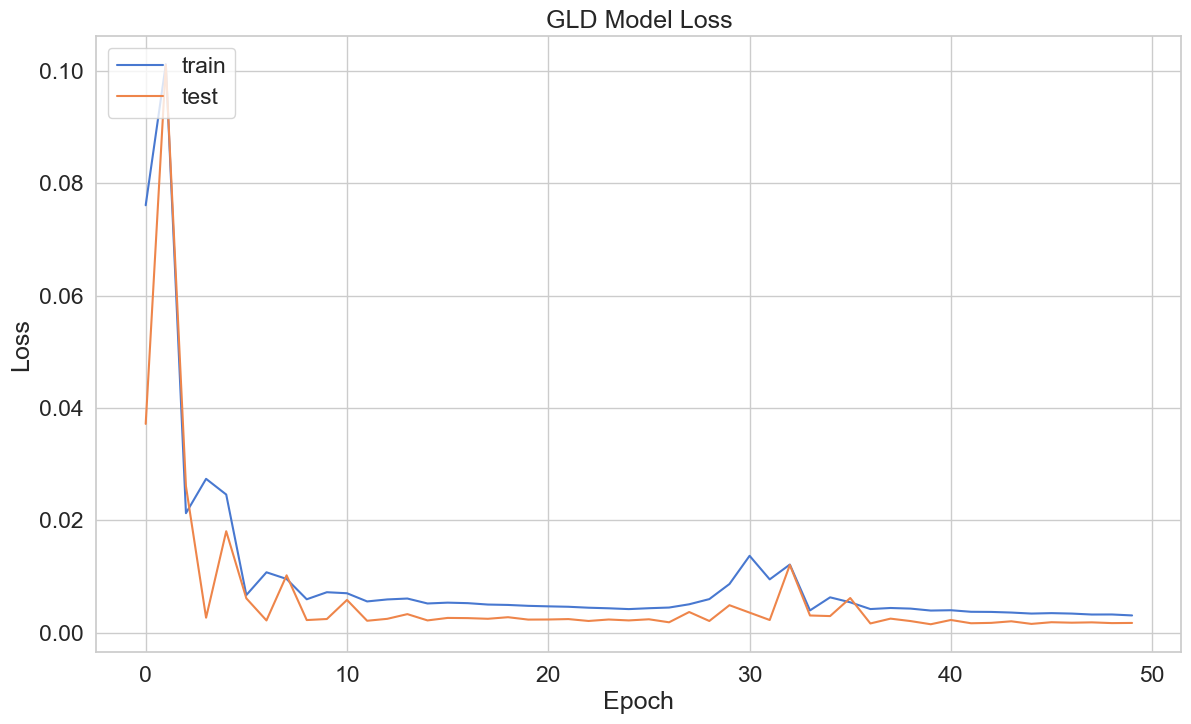

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 321ms/step


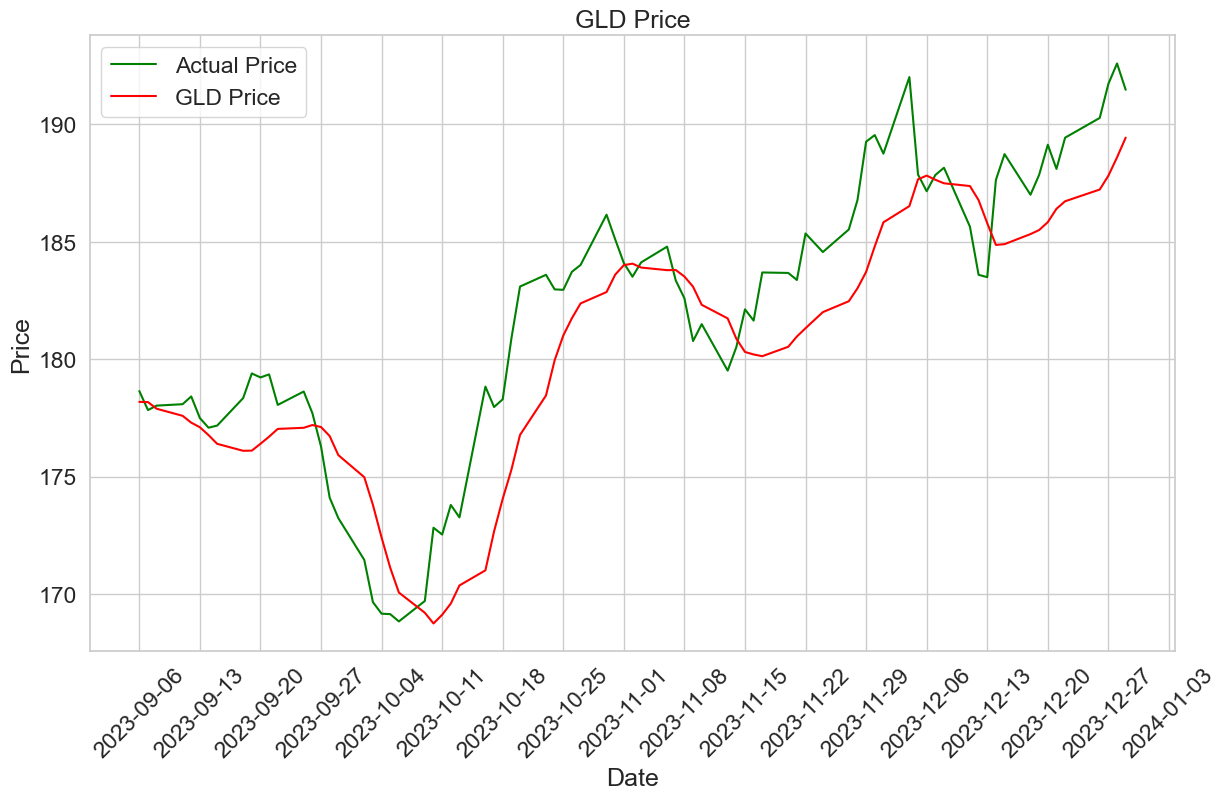

Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 587ms/step - loss: 0.1958 - val_loss: 0.0511
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 513ms/step - loss: 0.0531 - val_loss: 0.0031
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 473ms/step - loss: 0.0137 - val_loss: 0.0319
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 580ms/step - loss: 0.0303 - val_loss: 0.0051
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 431ms/step - loss: 0.0172 - val_loss: 0.0212
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 457ms/step - loss: 0.0224 - val_loss: 0.0033
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 486ms/step - loss: 0.0100 - val_loss: 0.0026
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 514ms/step - loss: 0.0080 - val_loss: 0.0081
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 470ms/step - loss: 0.0105 - val_loss: 0.0023
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 434ms/step - loss: 0.0077 - val_loss: 0.0032
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 537ms/step - loss: 0.0071 - val_loss: 0.0033
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 432ms/step - loss: 0.0071 - val_lo

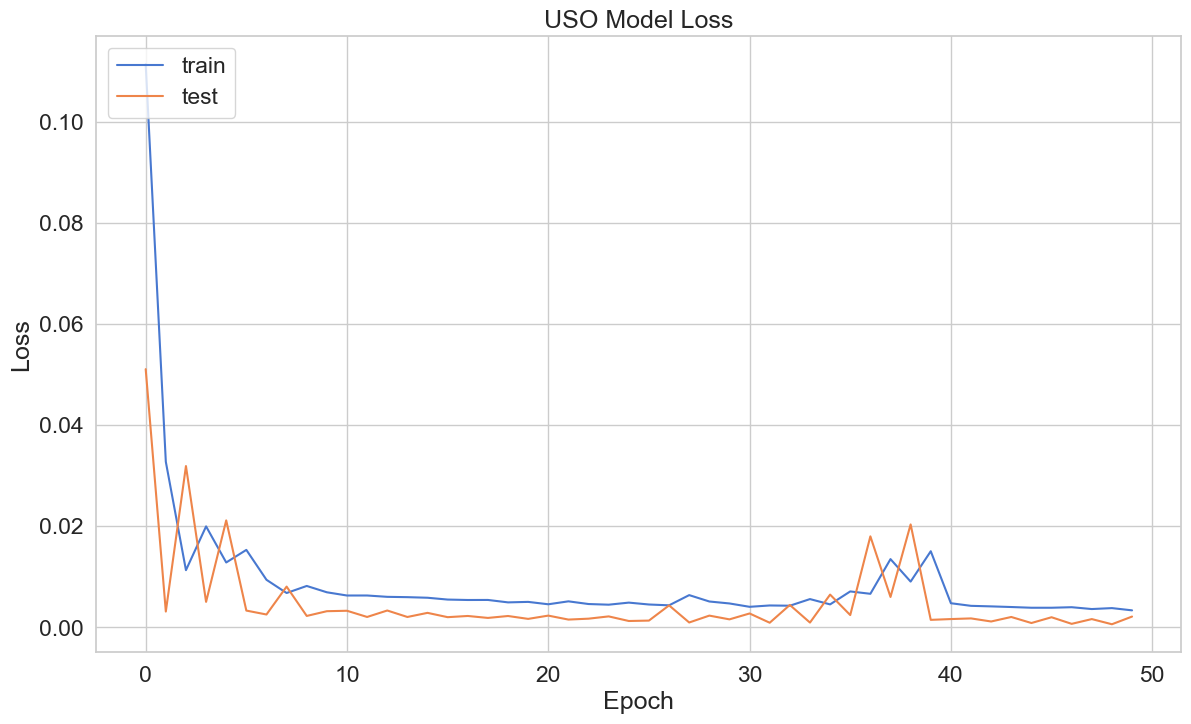

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 314ms/step


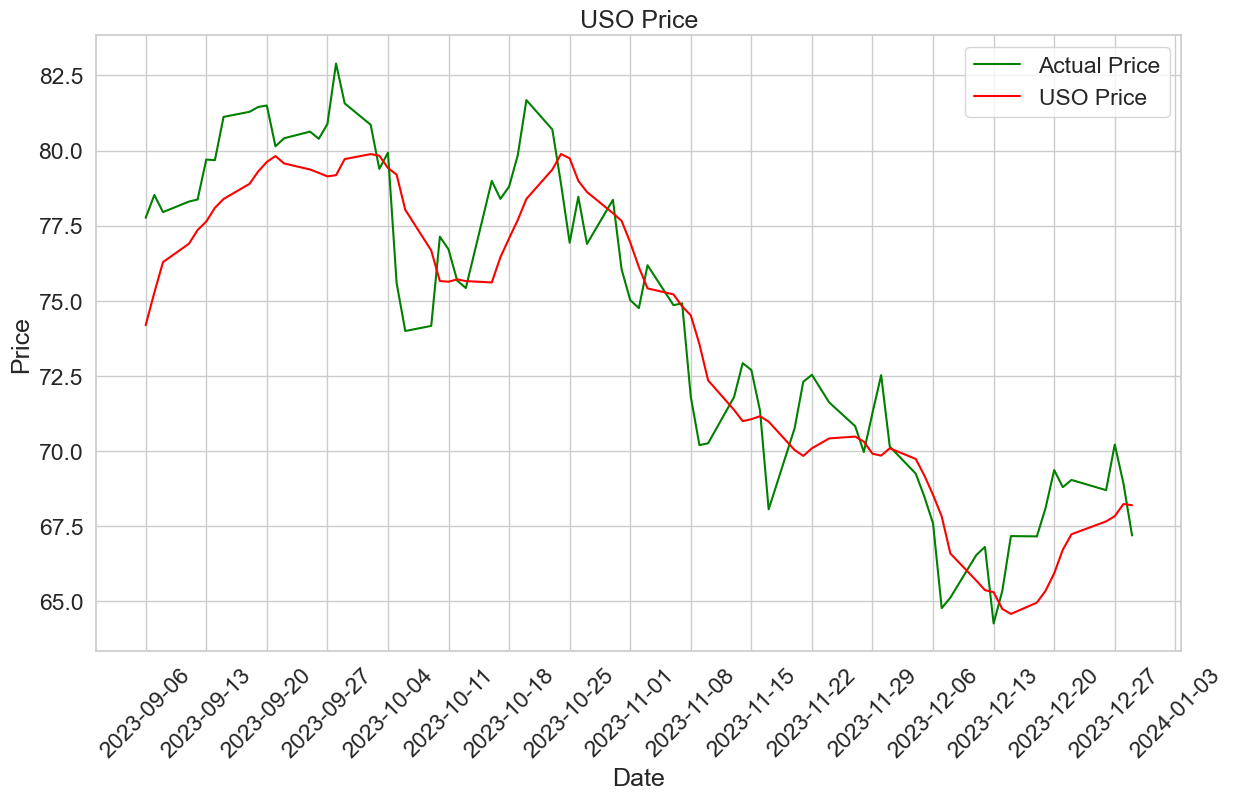

In [7]:
def main():

    models = {}
    histories = {}
    X_tests = {}
    y_tests = {}
    scalers = {}

    for asset in assets:
        csv_path = f'./data/{asset}_data.csv'
        df = pd.read_csv(csv_path, parse_dates=['Date'])
        close_price = df['Adj Close'].values.reshape(-1, 1)
        scaled_close = scaler.fit_transform(close_price)
        X_train, y_train, X_test, y_test = preprocess_data(scaled_close, SEQ_LEN, train_split=0.80)
        model, history = train_model(X_train, y_train, X_test, y_test)
        plot_loss(history, scaler, asset, df)
        predict_and_plot(model, X_test, y_test, scaler, asset, df)

        models[asset] = model
        histories[asset] = history
        X_tests[asset] = X_test
        y_tests[asset] = y_test
        scalers[asset] = scaler
    return models, histories, X_tests, y_tests, scalers

# Call the main function
models, histories, X_tests, y_tests, scalers = main()

In [8]:
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Function to calculate evaluation metrics
def calculate_metrics(model, X_test, y_test, scaler):
    y_hat = model.predict(X_test)
    y_test_inverse = scaler.inverse_transform(y_test)
    y_hat_inverse = scaler.inverse_transform(y_hat)
    mse = mean_squared_error(y_test_inverse, y_hat_inverse)
    rmse = mean_squared_error(y_test_inverse, y_hat_inverse, squared=False)
    mae = mean_absolute_error(y_test_inverse, y_hat_inverse)
    return mse, rmse, mae

# Main function to compare models
def compare_models(models, histories, assets):
    evaluation_results = []
    for currency in assets:
        model = models[currency]
        history = histories[currency]
        X_test = X_tests[currency]
        y_test = y_tests[currency]
        scaler = scalers[currency]
        mse, rmse, mae = calculate_metrics(model, X_test, y_test, scaler)
        evaluation_results.append({'Currency': currency, 'MSE': mse, 'RMSE': rmse, 'MAE': mae})
    return pd.DataFrame(evaluation_results)


# Call the comparison function
evaluation_table = compare_models(models, histories, assets)
print(evaluation_table)



3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step

/Users/ephraim888sun/.pyenv/versions/3.9.6/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step

/Users/ephraim888sun/.pyenv/versions/3.9.6/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step

/Users/ephraim888sun/.pyenv/versions/3.9.6/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step

/Users/ephraim888sun/.pyenv/versions/3.9.6/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step

/Users/ephraim888sun/.pyenv/versions/3.9.6/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step

/Users/ephraim888sun/.pyenv/versions/3.9.6/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step

/Users/ephraim888sun/.pyenv/versions/3.9.6/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step

/Users/ephraim888sun/.pyenv/versions/3.9.6/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step

/Users/ephraim888sun/.pyenv/versions/3.9.6/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step

/Users/ephraim888sun/.pyenv/versions/3.9.6/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step

/Users/ephraim888sun/.pyenv/versions/3.9.6/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
   Currency        MSE      RMSE       MAE
0      AAPL  11.395200  3.375678  2.844056
1      MSFT   5.649436  2.376854  2.042236
2      AMZN   5.624605  2.371625  2.107983
3     GOOGL   7.133465  2.670855  2.362855
4      TSLA   1.896918  1.377286  1.046978
5       SPY   4.569751  2.137698  1.785906
6       AGG   1.932195  1.390034  1.115307
7       PSP   2.548996  1.596557  1.219558
8       VNQ   2.688662  1.639714  1.265524
9       SLV   5.478493  2.340618  1.982645
10      GLD   6.884994  2.623927  2.162305
11      USO   3.755280  1.937854  1.647962


/Users/ephraim888sun/.pyenv/versions/3.9.6/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
